### Library import

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import neurokit2 as nk
import tensorflow as tf
import matplotlib.pyplot as plt

available GPU

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

list구조 [{'S10'}, {'S9'}, {'S8'} --- ]   
print(list_name[0]['S10'].keys())   
print(list_name[0]['S10']['Amuse'].keys())   
print(list_name[0]['S10']['Amuse']['segments'].keys())   
print(list_name[0]['S10']['Amuse']['heartbeat'].keys())   


### Data load

In [3]:
# def NAME_TO_DICT(name):
    
    
#     '''
#     input : name (파일이름)
#     output : name 이름을 가진 딕셔너리 
    
#     -설명 :
#     사람을 구별하기 위해 파일 이름으로,
#     list_name 리스트에 파일 이름을 가진 딕셔너리를 저장하기위해
#     딕셔너리 생성 후 반환 
#     '''
    
    
#     file_dict = {name : []}
#     return file_dict


def Get_ecg(data):
    
    
    '''
    Get_ECG in .pkl file
    
    input : data ()
    output : 각 클래스 별 ECG 
    
    -설명 : 
    WESAD databse의 .pkl file에서 ECG 데이터를 가져옵니다.
    Amuse, Normal, Stress data를 가져온 뒤 np.array 형태로 반환
    
    '''
    
    
    ecg_v = data['signal']['chest']['ECG'] # singl-chest-ecg 딕셔너리 값
    label = df['label']
    
    normal_ecg = np.array(ecg_v[np.where(label==1)[0]])
    stress_ecg = np.array(ecg_v[np.where(label==2)[0]])
    amuse_ecg = np.array(ecg_v[np.where(label==3)[0]])
    
    print('Get ecg success')
    
    return normal_ecg.flatten(), stress_ecg.flatten(), amuse_ecg.flatten()


def GET_SEGMENTS(signal, waves): 
    # create_dataset에서 호출되는 함수 
    
    
    '''
    -PQ, QRS, ST의 값들을 추출해서 segments 딕셔너리에 추가
    
    input : signal(해당 클래스 ECG 데이터), waves(Peak들의 지점 정보가 담긴 딕셔너리)
    output : Amuse, Normal, Stress에 대한 PQ, QRS, ST 데이터가 담긴 segments 딕셔너리
    
    설명 :
    신호와 peak지점들이 담긴 정보를 받는다.
    for문을 통해 클래스별로 PQ, QRS, ST 간격을 추출
    np.array 형태로 변환한 뒤 반환
    
    '''
    
    
    segments = {
        'PQ': [],
        'QRS': [],
        'ST': []
    }
    # NaN 값 판별 X 수정 필요 
    for i in range(len(waves['ECG_P_Peaks'])):
        if not np.isnan(waves['ECG_P_Onsets'][i]) and not np.isnan(waves['ECG_P_Offsets'][i]) and not np.isnan(waves['ECG_P_Offsets'][i]) and not np.isnan(waves['ECG_T_Onsets'][i]) and not np.isnan(waves['ECG_T_Onsets'][i]) and not np.isnan(waves['ECG_T_Offsets'][i]):
            segments['PQ'].append(signal[waves['ECG_P_Onsets'][i]: waves['ECG_P_Offsets'][i]])
            segments['QRS'].append(signal[waves['ECG_P_Offsets'][i]: waves['ECG_T_Onsets'][i]])
            segments['ST'].append(signal[waves['ECG_T_Onsets'][i]: waves['ECG_T_Offsets'][i]])
        
    # Convert lists to numpy arrays
    #for key in segments:
     #   segments[key] = np.array(segments[key])
    
    return segments


def GET_Heartbeat(signal, rpeaks, smapling_rate):
    # create_dataset에서 호출되는 함수 
    
    
    '''
    -PQRST 함수 추출 
    
    input : signal(ECG Data), rpeaks(해당 ECG 데이터의 Rpeak 지점), sampling_rate
    output : 한 주기 씩 저장된 딕셔너리 데이터
    
    설명 :
    해당 신호와 그 신호의 R지점 데이터를 받아 PQRST로 이루어진 한 주기를 추출
    뉴로킷의 nk.ecg_segment 이용
    
    '''
    
    
    segments_Heartbeat = {
        'Heartbeat' : []
    }
    
    qrs_epochs = nk.ecg_segment(signal, rpeaks=rpeaks, sampling_rate=smapling_rate, show=False)
    
    for i in range(1, len(qrs_epochs.keys())):
        segments_Heartbeat['Heartbeat'].append(qrs_epochs[str(i)]['Signal'])
    
    #for key in segments_Heartbeat:
    #    segments_Heartbeat[key] = np.array(segments_Heartbeat[key])
        
    return segments_Heartbeat



def create_dataset(datasets, sampling_rate = 700):
    
    '''
    3개 클래스의 모든 정보를 담긴 dataset을 생성하기 위한 함수
    
    input : datasets 딕셔너리, sampling_rate
    output : GET_SEGMENTS, GET_Heartbeat의 함수들을 통해 딕셔너리에 저장된 데이터와 클래스 라벨이 담긴 딕셔너리 반환
    
    설명 :
    -- Dict 형태 -- 
    1. [class][segments][PQ or QRS or ST] : PQ, QRS, ST 데이터가 담긴 dict
    2. [class][heartbeat][Heartbeat] : 한 주기가 차례대로 담긴 Heartbeat dict
    3. [class][label] : Class 라벨 (Amuse : 0, Normal : 1, Stress : 2)
    
    -- 참고 -- 
    label값, (data, waves, data_label)
    results['Normal, Stress, Amuse']['segments']['PQ', 'QRS', 'ST']
    results['Normal', 'Stress', 'Amuse']['label']
    
    -- 출력 예시 --
    -Example of accessing the results
    print(results['Normal']['segments']['PQ'])  # Access PQ segments for Normal
    print(results['Normal']['label'])           # Access label for Normal (0) 
    '''
    
    
    for label, (data, waves, rpeaks, data_label) in datasets.items(): # .items()를 통해 딕셔너리의 key, value 값을 얻을 수 있음
       
        results[label] = {
            'segments': GET_SEGMENTS(data, waves),
            'heartbeat' : GET_Heartbeat(data, rpeaks, 700),
            'label': data_label
        }
       
    print(results[label]['heartbeat']['Heartbeat'][0])
    return results

# 2024/4/22 03:43
# 문제 1 : 동일한 사람의 데이터가 result에 들어감 (해결)
# 문제 1-2 : numpy 로 변환하지않고 리스트로 동적으로 넣었는데 NAN 값을 조건에서 판별을 하지 않음 (해결)
# 문제 2 : 그리고 pq, qrs, st 개수가 맞아야하는데 맞지않음
### - Heartbeat와 PQ, QRS, ST는 따로 작동함

# 2024/4/23 04:44 문제 해결

# 본 코드

In [5]:
df = pd.read_pickle("D:/Database/WESAD/S2/S2.pkl")
normal, stress, amuse = Get_ecg(df)

Get ecg success


In [8]:
path = "D:/Database/WESAD/"
save_path = "D:/ICMLA/Database_pkl2/"
results = {}
sampling_rate = 700

for i in range(len(os.listdir(path))):
    for j in range(len(os.listdir(path + os.listdir(path)[2]))):
        if os.path.splitext(path+os.listdir(path)[i])[1] == '.pdf':
            break
        else :
            file_name = os.listdir(path+os.listdir(path)[i])[j]
            if os.path.splitext(file_name)[1] == '.pkl':
                df= pd.read_pickle(path + os.path.splitext(file_name)[0] + '/' + file_name)
                print(file_name + ' load success')
                
                Normal, Stress, Amuse = Get_ecg(df)
                print(Normal.shape, Stress.shape, Amuse.shape)

                # 클래스 별로 R-peak 감지 (neurokit 방법)
                _, normal_rpeaks = nk.ecg_peaks(Normal, sampling_rate=sampling_rate, show=False, method='neurokit')
                _, stress_rpeaks = nk.ecg_peaks(Stress, sampling_rate=sampling_rate, show=False, method='neurokit')
                _, amuse_rpeaks = nk.ecg_peaks(Amuse, sampling_rate=sampling_rate, show=False, method='neurokit')
                print('---------------R-peaks detection Success!---------------')

                # 클래스 별로 Peak 추출 
                normal_signals, normal_waves = nk.ecg_delineate(Normal, normal_rpeaks['ECG_R_Peaks'], sampling_rate=sampling_rate)
                stress_signals, stress_waves = nk.ecg_delineate(Stress, stress_rpeaks['ECG_R_Peaks'], sampling_rate=sampling_rate)
                amuse_signals, amuse_waves = nk.ecg_delineate(Amuse, amuse_rpeaks['ECG_R_Peaks'], sampling_rate=sampling_rate)
                print('---------------Signal Peaks delineate Success!---------------')
                print(normal_waves['ECG_P_Peaks'][0], stress_waves['ECG_P_Peaks'][0], amuse_waves['ECG_P_Peaks'][0])

                # datasets 딕셔너리를 생성한 뒤 해당 값들을 key, value 형태로 저장 
                print('---------------피크 추출 및 딕셔너리에 저장---------------')
                datasets = {
                'Amuse': (Amuse, amuse_waves, amuse_rpeaks['ECG_R_Peaks'], 0),# Label 0
                'Normal': (Normal, normal_waves, normal_rpeaks['ECG_R_Peaks'], 1), # Label 1
                'Stress': (Stress, stress_waves, stress_rpeaks['ECG_R_Peaks'], 2),  # Label 2
                }
                
                
                results = create_dataset(datasets, sampling_rate = sampling_rate)
                
                with open(save_path+file_name+'.pkl', 'wb') as f:
                    pickle.dump(results, f)
                
                

                print("-----------------" ,os.path.splitext(file_name)[0], "전처리 완료---------------------")

                break
            else:
                print(i,j)
                break
    


S10.pkl load success
Get ecg success
(826000,) (507500,) (260400,)
---------------R-peaks detection Success!---------------
---------------Signal Peaks delineate Success!---------------
209 303 655
---------------피크 추출 및 딕셔너리에 저장---------------
-0.195963    0.092285
-0.194531    0.096497
-0.193099    0.099335
-0.191667    0.107986
-0.190235    0.107986
               ...   
 0.358203    0.136047
 0.359635    0.147766
 0.361067    0.162460
 0.362499    0.178024
 0.363931    0.181961
Name: Signal, Length: 392, dtype: float64
----------------- S10 전처리 완료---------------------
S11.pkl load success
Get ecg success
(826000,) (476000,) (257600,)
---------------R-peaks detection Success!---------------
---------------Signal Peaks delineate Success!---------------
635 255 594
---------------피크 추출 및 딕셔너리에 저장---------------
-0.168455    0.002975
-0.167018    0.014969
-0.165581    0.014465
-0.164145    0.013824
-0.162708    0.007370
               ...   
 0.307097    0.182007
 0.308534    0.177475


---------------Signal Peaks delineate Success!---------------
369 195 614
---------------피크 추출 및 딕셔너리에 저장---------------
-0.262784   -0.072556
-0.261351   -0.070084
-0.259919   -0.067703
-0.258486   -0.067932
-0.257053   -0.068710
               ...   
 0.482297    0.172531
 0.483730    0.181274
 0.485162    0.185349
 0.486595    0.184067
 0.488028    0.180817
Name: Signal, Length: 525, dtype: float64
----------------- S9 전처리 완료---------------------


# 시각화

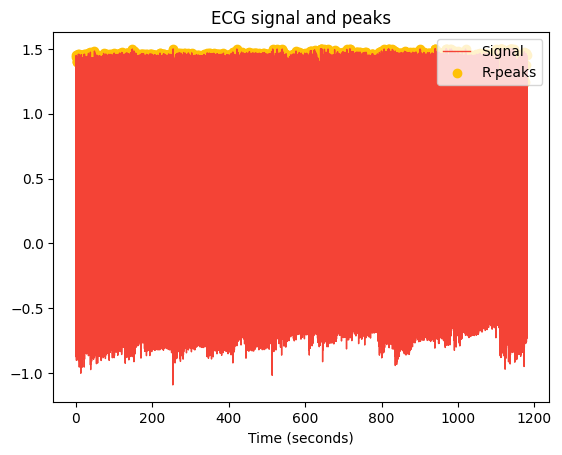

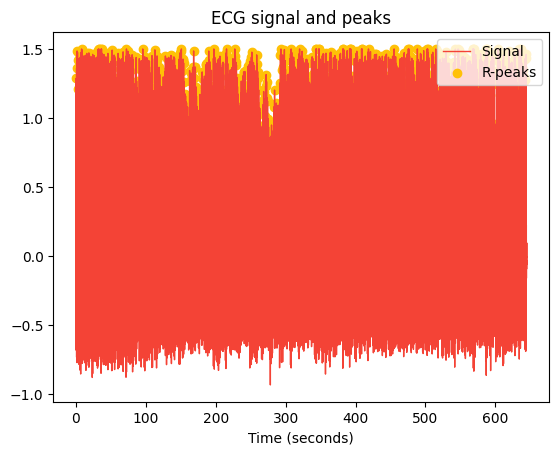

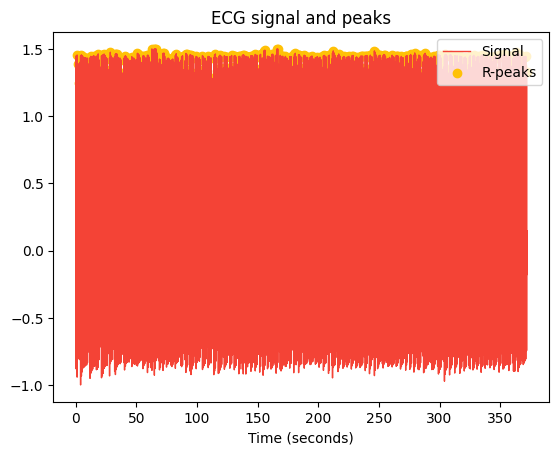

In [311]:
_, normal_rpeaks = nk.ecg_peaks(Normal, sampling_rate=700, show=True,method='neurokit')
_, stress_rpeaks = nk.ecg_peaks(Stress, sampling_rate=700, show=True,method='neurokit')
_, amuse_rpeaks = nk.ecg_peaks(Amuse, sampling_rate=700, show=True,method='neurokit')

### Feature Extraction

## P-Q 시각화

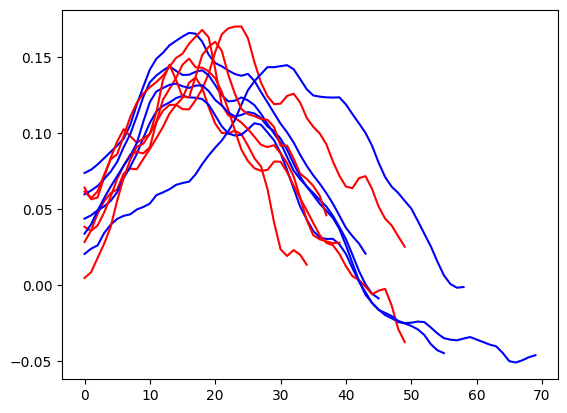

In [9]:
for i in range(100,105):
    plt.plot(normal_ecg[waves['ECG_P_Onsets'][i-1] : waves['ECG_P_Offsets'][i-1]], color='blue', label='Normal')
    plt.plot(stress_ecg[stress_waves['ECG_P_Onsets'][i-1] : stress_waves['ECG_P_Offsets'][i-1]], color='red', label='stress')

## QRS 시각화

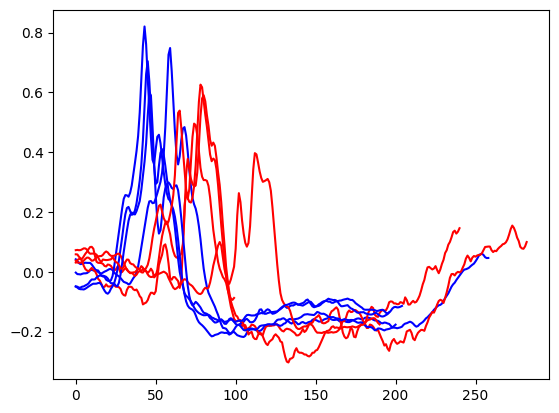

In [10]:
for i in range(1,5):
    plt.plot(normal_ecg[waves['ECG_P_Offsets'][i-1] : waves['ECG_T_Onsets'][i-1]], color='blue', label='Normal')
    plt.plot(stress_ecg[stress_waves['ECG_P_Offsets'][i-1] : stress_waves['ECG_T_Onsets'][i-1]], color='red', label='stress')

# S-T 시각화

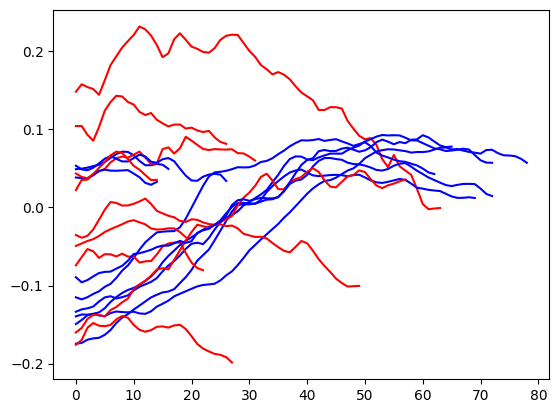

In [11]:
for i in range(1,10):
    plt.plot(normal_ecg[waves['ECG_T_Onsets'][i-1] : waves['ECG_T_Offsets'][i-1]], color='blue', label='Normal')
    plt.plot(stress_ecg[stress_waves['ECG_T_Onsets'][i-1] : stress_waves['ECG_T_Offsets'][i-1]], color='red', label='stress')

## Heartbeat 시각화 (Normal vs Stress)

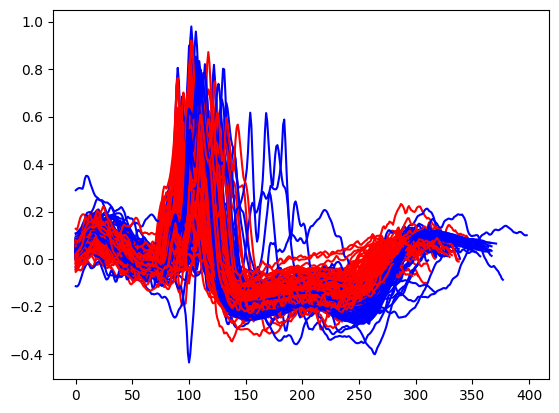

In [12]:
for i in range(1,100):
    plt.plot(normal_ecg[waves['ECG_P_Onsets'][i-1] : waves['ECG_T_Offsets'][i-1]], color='blue', label='Normal')
    plt.plot(stress_ecg[stress_waves['ECG_P_Onsets'][i-1] : stress_waves['ECG_T_Offsets'][i-1]], color='red', label='stress')